Import libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from datetime import datetime
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score)
import category_encoders as ce
plt.style.use("seaborn-v0_8")
plt.rcParams['figure.figsize'] = (10,5)


Load Datasets

In [2]:
# Load Historical Trader Data
trader_data = pd.read_csv(r"C:\Users\Shradha Dedha\Downloads\historical_data.csv")  

# Load Bitcoin Market Sentiment Data
sentiment_data = pd.read_csv(r"C:\Users\Shradha Dedha\Downloads\fear_greed_index.csv")  


Inspect and Clean data

In [3]:
# Trader data
print(trader_data.info())
print(trader_data.describe())
print(trader_data.isnull().sum())

# Sentiment data
print(sentiment_data.info())
print(sentiment_data.describe())
print(sentiment_data.isnull().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211224 entries, 0 to 211223
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Account           211224 non-null  object 
 1   Coin              211224 non-null  object 
 2   Execution Price   211224 non-null  float64
 3   Size Tokens       211224 non-null  float64
 4   Size USD          211224 non-null  float64
 5   Side              211224 non-null  object 
 6   Timestamp IST     211224 non-null  object 
 7   Start Position    211224 non-null  float64
 8   Direction         211224 non-null  object 
 9   Closed PnL        211224 non-null  float64
 10  Transaction Hash  211224 non-null  object 
 11  Order ID          211224 non-null  int64  
 12  Crossed           211224 non-null  bool   
 13  Fee               211224 non-null  float64
 14  Trade ID          211224 non-null  float64
 15  Timestamp         211224 non-null  float64
dtypes: bool(1), float64(

In [4]:
print(trader_data.columns)
print(sentiment_data.columns)

Index(['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side',
       'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL',
       'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID',
       'Timestamp'],
      dtype='object')
Index(['timestamp', 'value', 'classification', 'date'], dtype='object')


In [8]:

# Check first rows
trader_data.head()
sentiment_data.head()

# Explicitly define the format of your timestamps
trader_data['Timestamp IST'] = pd.to_datetime(trader_data['Timestamp IST'], format='%d-%m-%Y %H:%M', errors='coerce')

# Check if any rows could not be converted
print(trader_data[trader_data['Timestamp IST'].isna()])

# For sentiment data (assuming 'date' is 'DD-MM-YYYY')
sentiment_data['date'] = pd.to_datetime(sentiment_data['date'], format='%d-%m-%Y', errors='coerce')




Empty DataFrame
Columns: [Account, Coin, Execution Price, Size Tokens, Size USD, Side, Timestamp IST, Start Position, Direction, Closed PnL, Transaction Hash, Order ID, Crossed, Fee, Trade ID, Timestamp]
Index: []


In [9]:
trader_data.dropna(subset=['Timestamp IST'], inplace=True)
sentiment_data.dropna(subset=['date'], inplace=True)


Aggregate Trade Data Daily

In [12]:
daily_trader = trader_data.groupby(trader_data['Timestamp IST'].dt.date).agg({
    'Closed PnL': ['sum', 'mean'],
    'Size USD': 'sum',
    'Fee': 'mean'
})

# Check the columns
print(daily_trader.columns)


MultiIndex([('Closed PnL',  'sum'),
            ('Closed PnL', 'mean'),
            (  'Size USD',  'sum'),
            (       'Fee', 'mean')],
           )


In [13]:


# Flatten column names
daily_trader.columns = ['total_PnL', 'avg_PnL', 'total_volume', 'avg_fee']

# Flatten columns automatically
daily_trader.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in daily_trader.columns]
print(daily_trader.columns)



Index(['total_PnL', 'avg_PnL', 'total_volume', 'avg_fee'], dtype='object')


In [14]:
daily_trader.rename(columns={
    'Closed PnL_sum': 'total_PnL',
    'Closed PnL_mean': 'avg_PnL',
    'Size USD_sum': 'total_volume',
    'Fee_mean': 'avg_fee'
}, inplace=True)


In [16]:

# Create a new column for the date only
trader_data['date_only'] = trader_data['Timestamp IST'].dt.date

# Aggregate daily metrics
daily_trader = trader_data.groupby('date_only').agg({
    'Closed PnL': ['sum', 'mean'],
    'Size USD': 'sum',
    'Fee': 'mean'
})

# Flatten MultiIndex columns
daily_trader.columns = ['total_PnL', 'avg_PnL', 'total_volume', 'avg_fee']

# Reset index to make 'date_only' a column
daily_trader = daily_trader.reset_index()

# Rename column to 'Date' and convert to datetime
daily_trader.rename(columns={'date_only': 'Date'}, inplace=True)
daily_trader['Date'] = pd.to_datetime(daily_trader['Date'])




Merged with Sentiment data

In [17]:
# Make sure sentiment date column is datetime
sentiment_data['date'] = pd.to_datetime(sentiment_data['date'], format='%d-%m-%Y', errors='coerce')

# Merge on date
merged_data = pd.merge(daily_trader, sentiment_data, left_on='Date', right_on='date', how='inner')

# Encode sentiment numerically
merged_data['sentiment_num'] = merged_data['classification'].map({'Fear':0, 'Greed':1})

merged_data.head()


,Date,total_PnL,avg_PnL,total_volume,avg_fee,timestamp,value,classification,date,sentiment_num
0,2023-05-01,0.000000,0.000000,477.00,0.000000,1.682919e+09,63.0,Greed,2023-05-01,1.0
1,2023-12-05,0.000000,0.000000,50005.83,1.389051,1.701754e+09,75.0,Extreme Greed,2023-12-05,NaN
2,2023-12-14,-205.434737,-18.675885,113203.35,2.572803,1.702532e+09,72.0,Greed,2023-12-14,1.0
3,2023-12-15,-24.632034,-12.316017,10609.95,1.326245,1.702618e+09,70.0,Greed,2023-12-15,1.0
4,2023-12-16,0.000000,0.000000,15348.77,1.279063,1.702705e+09,67.0,Greed,2023-12-16,1.0


Exploratory Data Analysis (EDA)

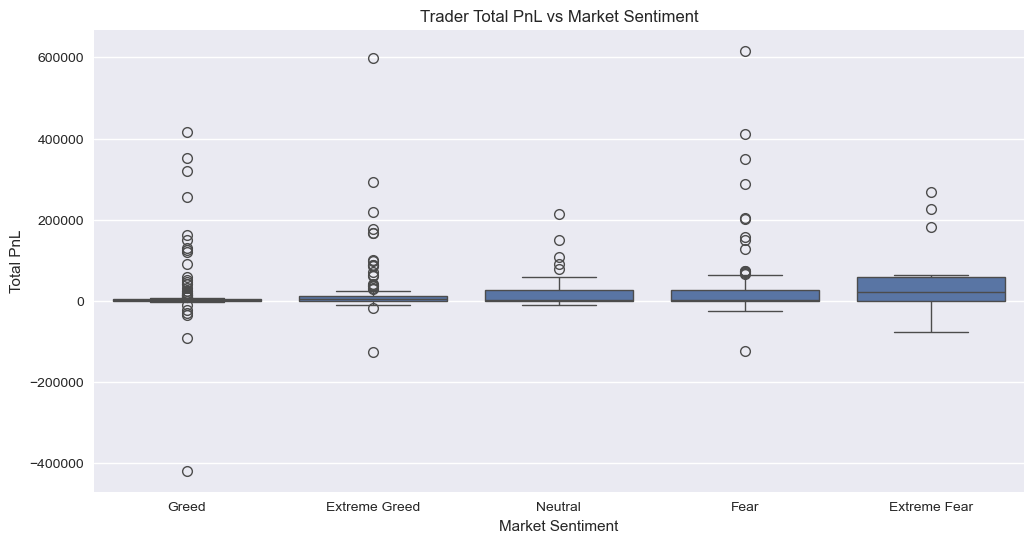

In [29]:

#PnL vs Market Sentiment
plt.figure(figsize=(12,6))
sns.boxplot(x='classification', y='total_PnL', data=merged_data)
plt.title('Trader Total PnL vs Market Sentiment')
plt.xlabel('Market Sentiment')
plt.ylabel('Total PnL')
plt.show()


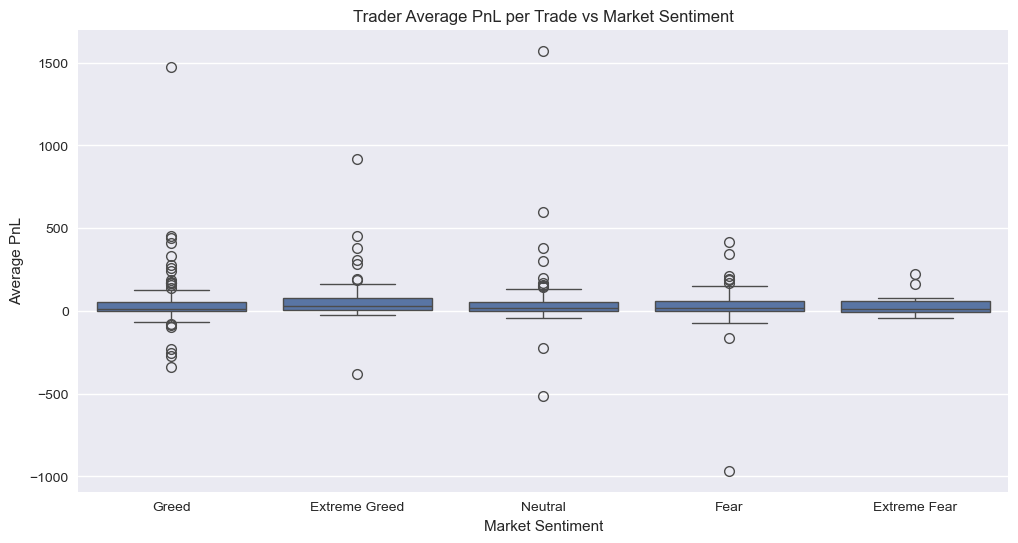

In [28]:
#Average PnL vs Sentiment
plt.figure(figsize=(12,6))
sns.boxplot(x='classification', y='avg_PnL', data=merged_data)
plt.title('Trader Average PnL per Trade vs Market Sentiment')
plt.xlabel('Market Sentiment')
plt.ylabel('Average PnL')
plt.show()


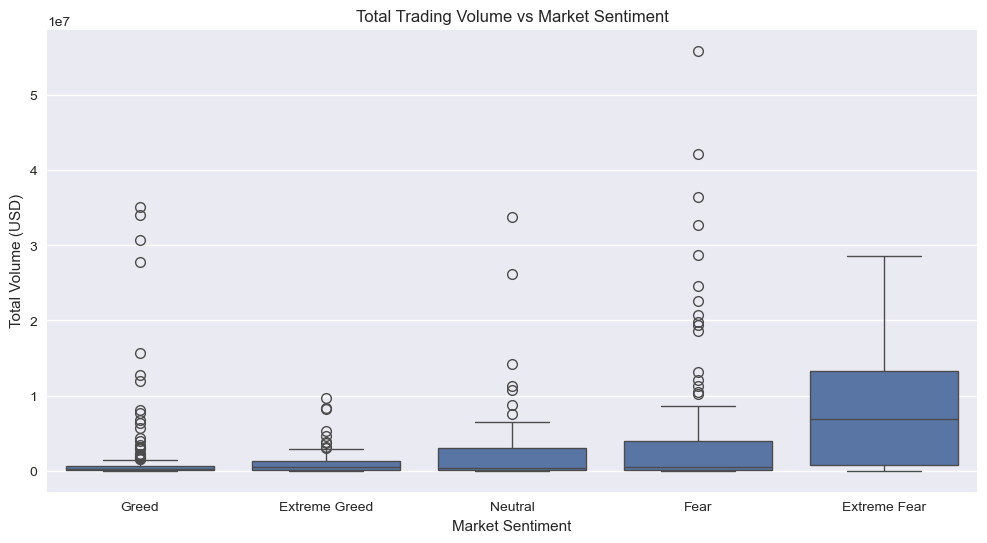

In [27]:
#Total Volume vs Sentiment
plt.figure(figsize=(12,6))
sns.boxplot(x='classification', y='total_volume', data=merged_data)
plt.title('Total Trading Volume vs Market Sentiment')
plt.xlabel('Market Sentiment')
plt.ylabel('Total Volume (USD)')
plt.show()


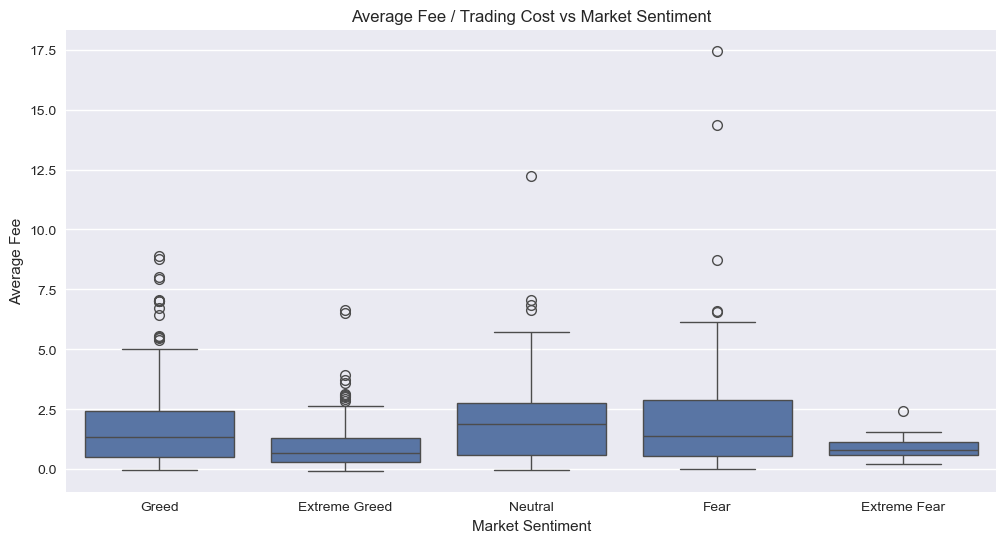

In [26]:
#Average Fee (Risk Proxy) vs Sentiment
plt.figure(figsize=(12,6))
sns.boxplot(x='classification', y='avg_fee', data=merged_data)
plt.title('Average Fee / Trading Cost vs Market Sentiment')
plt.xlabel('Market Sentiment')
plt.ylabel('Average Fee')
plt.show()


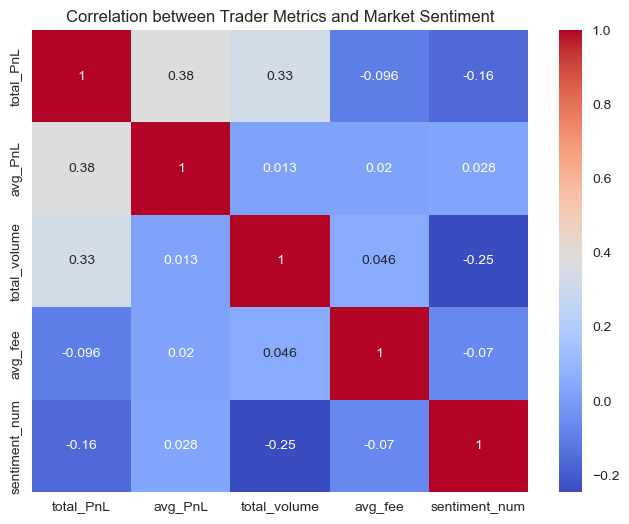

In [25]:
#Correlation Heatmap
plt.figure(figsize=(8,6))
sns.heatmap(
    merged_data[['total_PnL','avg_PnL','total_volume','avg_fee','sentiment_num']].corr(),
    annot=True, cmap='coolwarm'
)
plt.title('Correlation between Trader Metrics and Market Sentiment')
plt.show()


Trend analysis over time

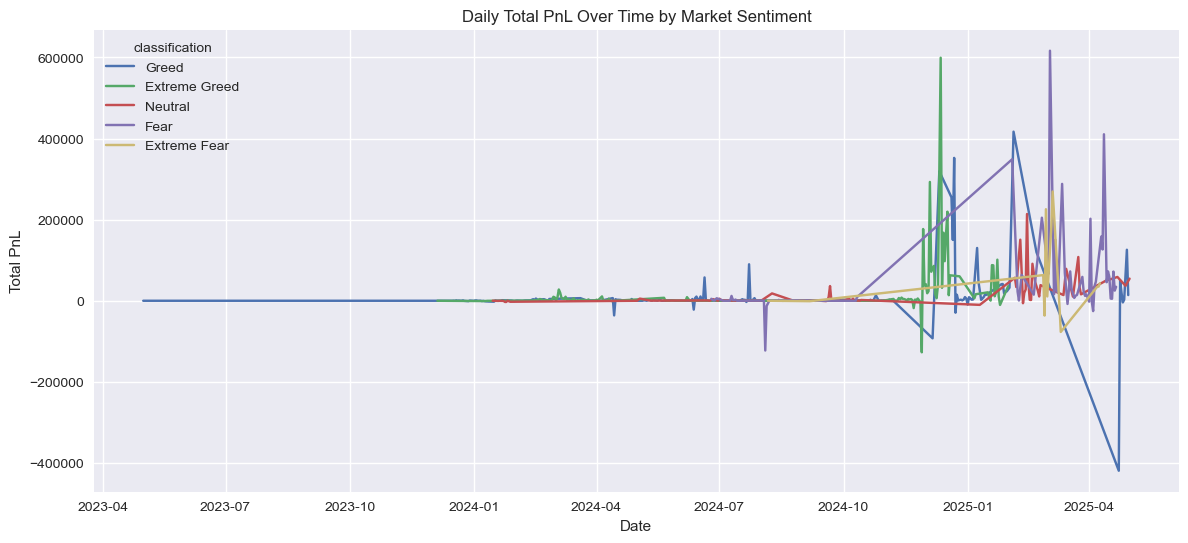

In [24]:
# Daily Total PnL Trend
plt.figure(figsize=(14,6))
sns.lineplot(x='Date', y='total_PnL', hue='classification', data=merged_data)
plt.title('Daily Total PnL Over Time by Market Sentiment')
plt.xlabel('Date')
plt.ylabel('Total PnL')
plt.show()


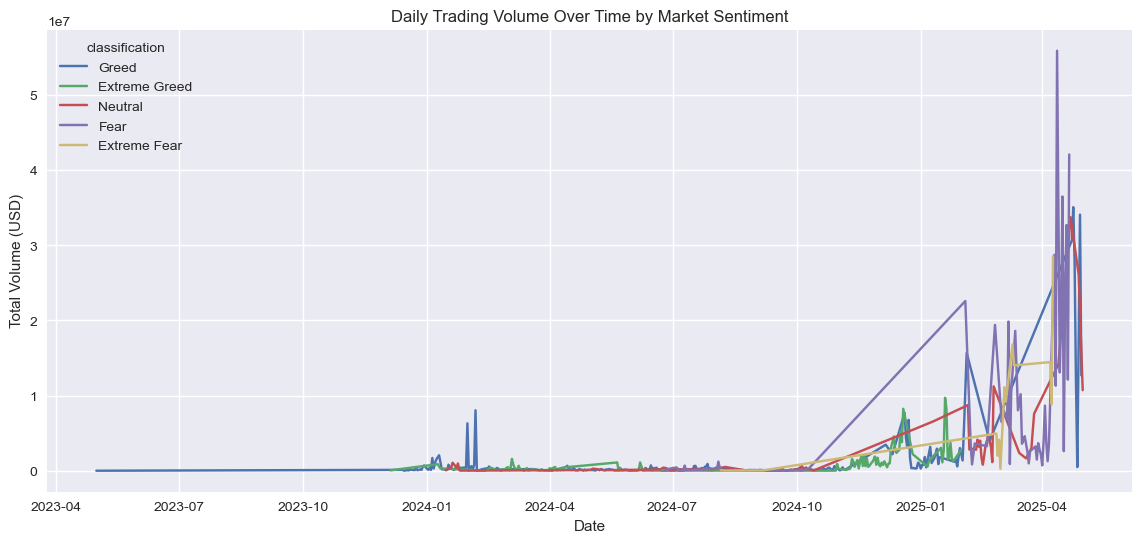

In [30]:
#Daily Trading Volume Trend
plt.figure(figsize=(14,6))
sns.lineplot(x='Date', y='total_volume', hue='classification', data=merged_data)
plt.title('Daily Trading Volume Over Time by Market Sentiment')
plt.xlabel('Date')
plt.ylabel('Total Volume (USD)')
plt.show()


Statistical Significance Tests

In [34]:
from scipy.stats import ttest_ind

# Separate metrics by sentiment
fear_data = merged_data[merged_data['classification'] == 'Fear']
greed_data = merged_data[merged_data['classification'] == 'Greed']

# Total PnL t-test
t_stat, p_val = ttest_ind(fear_data['total_PnL'], greed_data['total_PnL'], equal_var=False)
print(f"Total PnL t-test: t={t_stat:.2f}, p={p_val:.4f}")

# Total Volume t-test
t_stat_vol, p_val_vol = ttest_ind(fear_data['total_volume'], greed_data['total_volume'], equal_var=False)
print(f"Total Volume t-test: t={t_stat_vol:.2f}, p={p_val_vol:.4f}")

# Avg Fee t-test
t_stat_fee, p_val_fee = ttest_ind(fear_data['avg_fee'], greed_data['avg_fee'], equal_var=False)
print(f"Average Fee t-test: t={t_stat_fee:.2f}, p={p_val_fee:.4f}")


Total PnL t-test: t=2.32, p=0.0217
Total Volume t-test: t=3.39, p=0.0010
Average Fee t-test: t=1.03, p=0.3054


Regression Analysis

In [38]:

# Check for missing values in X and y
print(merged_data[['sentiment_num','total_volume','avg_fee','total_PnL']].isna().sum())

# Check for infinite values
print(np.isinf(merged_data[['sentiment_num','total_volume','avg_fee','total_PnL']]).sum())



sentiment_num    195
total_volume       0
avg_fee            0
total_PnL          0
dtype: int64
sentiment_num    0
total_volume     0
avg_fee          0
total_PnL        0
dtype: int64


In [39]:
# Select relevant columns
reg_data = merged_data[['sentiment_num','total_volume','avg_fee','total_PnL']].copy()

# Replace inf with NaN
reg_data.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop rows with any NaN
reg_data.dropna(inplace=True)

# Define X and y
X = reg_data[['sentiment_num', 'total_volume', 'avg_fee']]
y = reg_data['total_PnL']

# Add constant for intercept
import statsmodels.api as sm
X = sm.add_constant(X)

# Run regression
model = sm.OLS(y, X).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:              total_PnL   R-squared:                       0.151
Model:                            OLS   Adj. R-squared:                  0.142
Method:                 Least Squares   F-statistic:                     16.59
Date:                Wed, 24 Sep 2025   Prob (F-statistic):           6.00e-10
Time:                        01:50:06   Log-Likelihood:                -3570.5
No. Observations:                 284   AIC:                             7149.
Df Residuals:                     280   BIC:                             7164.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          2.441e+04   9010.654      2.709

Extreme Sentiment Days

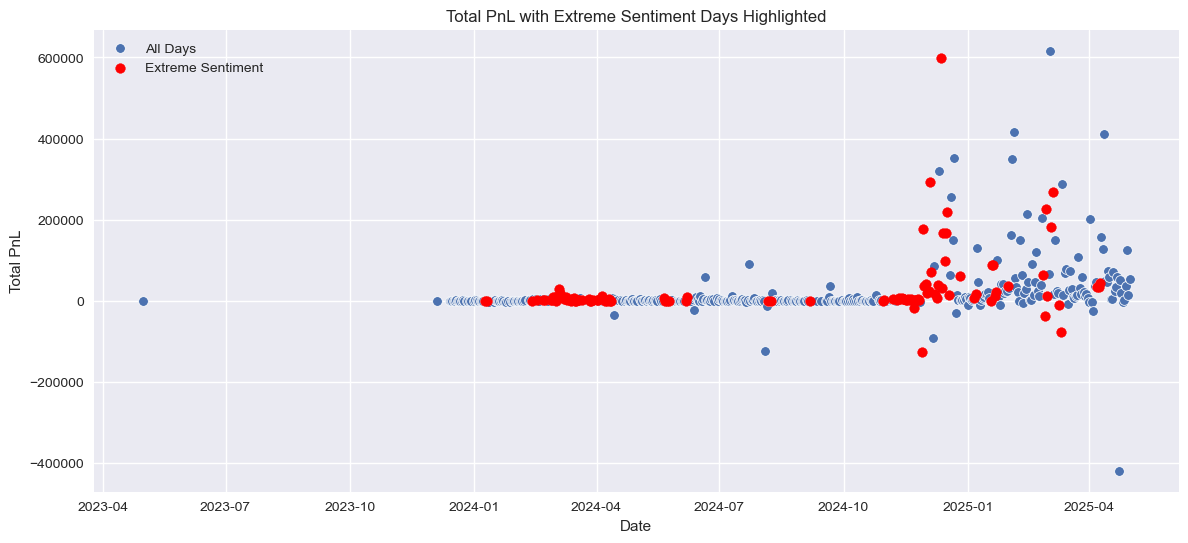

In [41]:
# Make a copy of the slice before modifying
extreme_sentiment = extreme_sentiment.copy()
# Now safely convert 'date' to datetime
extreme_sentiment['date'] = pd.to_datetime(extreme_sentiment['date'])


# Convert 'date' column to datetime if not already
extreme_sentiment['date'] = pd.to_datetime(extreme_sentiment['date'])

# Filter merged_data to only extreme sentiment days
extreme_data = merged_data[merged_data['Date'].isin(extreme_sentiment['date'])]

plt.figure(figsize=(14,6))

# Plot all daily total PnL
sns.scatterplot(x='Date', y='total_PnL', data=merged_data, label='All Days')

# Overlay extreme sentiment points
plt.scatter(extreme_data['Date'], extreme_data['total_PnL'],
            color='red', label='Extreme Sentiment', zorder=5)

plt.title('Total PnL with Extreme Sentiment Days Highlighted')
plt.xlabel('Date')
plt.ylabel('Total PnL')
plt.legend()
plt.show()



In [42]:

import os

os.makedirs("csv_files", exist_ok=True)


In [44]:
# Save raw trader data
trader_data.to_csv("csv_files/raw_trader_data.csv", index=False)

# Save sentiment data
sentiment_data.to_csv("csv_files/raw_sentiment_data.csv", index=False)

# Save daily trader summary
daily_trader.to_csv("csv_files/daily_trader.csv", index=False)

# Save merged dataset
merged_data.to_csv("csv_files/merged_sentiment_trader.csv", index=False)

# Save regression-ready dataset
reg_data.to_csv("csv_files/regression_input.csv", index=False)


In [45]:
check = pd.read_csv("csv_files/merged_sentiment_trader.csv")
print(check.head())


         Date   total_PnL    avg_PnL  total_volume   avg_fee     timestamp  \
0  2023-05-01    0.000000   0.000000        477.00  0.000000  1.682919e+09   
1  2023-12-05    0.000000   0.000000      50005.83  1.389051  1.701754e+09   
2  2023-12-14 -205.434737 -18.675885     113203.35  2.572803  1.702532e+09   
3  2023-12-15  -24.632034 -12.316017      10609.95  1.326245  1.702618e+09   
4  2023-12-16    0.000000   0.000000      15348.77  1.279063  1.702705e+09   

   value classification        date  sentiment_num  
0   63.0          Greed  2023-05-01            1.0  
1   75.0  Extreme Greed  2023-12-05            NaN  
2   72.0          Greed  2023-12-14            1.0  
3   70.0          Greed  2023-12-15            1.0  
4   67.0          Greed  2023-12-16            1.0  


In [46]:
import os
os.getcwd()


'C:\\Users\\Shradha Dedha'

In [47]:
os.listdir("csv_files")


['daily_trader.csv',
 'merged_sentiment_trader.csv',
 'raw_sentiment_data.csv',
 'raw_trader_data.csv',
 'regression_input.csv']

In [48]:
import os
import shutil

# Define the new root folder
root_dir = "ds_Shradha"
csv_dir = os.path.join(root_dir, "csv_files")

# Create folders if not exist
os.makedirs(csv_dir, exist_ok=True)

# List of files you already generated
files_to_move = [
    "csv_files/raw_trader_data.csv",
    "csv_files/raw_sentiment_data.csv",
    "csv_files/daily_trader.csv",
    "csv_files/merged_sentiment_trader.csv",
    "csv_files/regression_input.csv"
]

# Move them into the new folder
for file in files_to_move:
    if os.path.exists(file):
        shutil.move(file, csv_dir)
        print(f"Moved {file} → {csv_dir}")
    else:
        print(f"⚠️ File not found: {file}")


Moved csv_files/raw_trader_data.csv → ds_Shradha\csv_files
Moved csv_files/raw_sentiment_data.csv → ds_Shradha\csv_files
Moved csv_files/daily_trader.csv → ds_Shradha\csv_files
Moved csv_files/merged_sentiment_trader.csv → ds_Shradha\csv_files
Moved csv_files/regression_input.csv → ds_Shradha\csv_files


In [49]:
import glob
print(glob.glob("ds_Shradha/csv_files/*.csv"))

['ds_Shradha/csv_files\\daily_trader.csv', 'ds_Shradha/csv_files\\merged_sentiment_trader.csv', 'ds_Shradha/csv_files\\raw_sentiment_data.csv', 'ds_Shradha/csv_files\\raw_trader_data.csv', 'ds_Shradha/csv_files\\regression_input.csv']
